# Limpieza de los set de datos

In [1]:
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
import os
path_working_directory = os.getcwd()

educacion = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_1_postulantes_educacion.csv"), low_memory=False)
genero_edad = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_2_postulantes_genero_y_edad.csv"), low_memory=False)
visitas = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_3_vistas.csv"), low_memory=False)
postulaciones = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_4_postulaciones.csv"), low_memory=False)
avisos_online = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_5_avisos_online.csv"), low_memory=False)
avisos_detalles = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_6_avisos_detalle.csv"), low_memory=False)

### Set de genero y fechas de nacimiento

In [3]:
print "Cantidad de usuarios:", len(genero_edad), '\n'
print "Los usuarios son unicos:", len(genero_edad) == len(genero_edad.groupby('idpostulante')), '\n'
print genero_edad.isnull().any(), '\n'
print genero_edad.isnull().sum(), '\n'
print genero_edad.dtypes, '\n'

Cantidad de usuarios: 200888 

Los usuarios son unicos: True 

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool 

idpostulante          0
fechanacimiento    4750
sexo                  0
dtype: int64 

idpostulante       object
fechanacimiento    object
sexo               object
dtype: object 



Como se puede observar, existen 4750 usuarios de 200888 que no declaran su fecha de nacimiento (es decir, aproximadamente un 2,36%). Para que el set de datos este completo se podria rellenar los datos faltantes realizando una regresion o sacando un promedio siguiendo algun tipo de criterio. Sin embargo, como la cantidad de usuarios en cuestion es baja, se los puede eliminar del set de datos. Antes de realizar esto se analizara cuantas postulaciones y visitas corresponden a usuarios sin fecha de nacimiento, para ver si eliminar dichos usuarios implica quitar muchas postulaciones y visitas a avisos de los demas sets de datos.

In [4]:
no_declaran_edad = genero_edad[genero_edad.fechanacimiento.isnull()]
print len(no_declaran_edad), "postulantes no declaran edad", '\n'
declaran_edad = genero_edad[genero_edad.fechanacimiento.notnull()]
print len(declaran_edad), "postulantes declaran edad", '\n'
postulaciones_sin_fecha_nacimiento = pd.merge(no_declaran_edad, postulaciones, how='inner', on='idpostulante')
print len(postulaciones_sin_fecha_nacimiento), "postulaciones de usuarios sin fecha de nacimiento de", len(postulaciones), '\n'
visitas_sin_fecha_nacimiento = pd.merge(no_declaran_edad, visitas, how='inner', on='idpostulante')
print len(visitas_sin_fecha_nacimiento), "visitas de usuarios sin fecha de nacimiento de", len(visitas)

4750 postulantes no declaran edad 

196138 postulantes declaran edad 

44464 postulaciones de usuarios sin fecha de nacimiento de 3401623 

22767 visitas de usuarios sin fecha de nacimiento de 961897


Aproximadamente un 1,31% de las postulaciones corresponden a usuarios sin fecha de nacimiento mientras que en el caso de las visitas es de un 2,37%. Teniendo en cuenta que estos valores son pequenos, podemos optar por eliminar los usuarios sin fecha de nacimiento (y hacer lo propio con sus postulaciones y visitas a avisos)

In [5]:
genero_edad_filtrado = genero_edad[genero_edad.fechanacimiento.notnull()]

In [6]:
len(genero_edad_filtrado)

196138

### Set de estudios

In [7]:
print educacion.isnull().any(), '\n'
print educacion.describe(include='all'), '\n'
print educacion.dtypes, '\n'
print educacion.nombre.value_counts(), '\n'
print educacion.estado.value_counts(), '\n'

idpostulante    False
nombre          False
estado          False
dtype: bool 

       idpostulante      nombre    estado
count        298231      298231    298231
unique       188752           7         3
top          YlMLGD  Secundario  Graduado
freq              9      110256    194474 

idpostulante    object
nombre          object
estado          object
dtype: object 

Secundario           110256
Universitario        104295
Terciario/Técnico     47733
Otro                  24748
Posgrado               7387
Master                 3598
Doctorado               214
Name: nombre, dtype: int64 

Graduado      194474
En Curso       78531
Abandonado     25226
Name: estado, dtype: int64 



Se puede observar que en algunos casos existen multiples entradas de estudio por usuario. A continuacion se analizara el caso del usuario que tiene mas entadas, cuyo id es YlMLGD:

In [8]:
educacion[educacion['idpostulante'] == 'YlMLGD']

,idpostulante,nombre,estado
373,YlMLGD,Terciario/Técnico,En Curso
374,YlMLGD,Otro,En Curso
375,YlMLGD,Universitario,En Curso
2206,YlMLGD,Terciario/Técnico,Graduado
2207,YlMLGD,Universitario,Graduado
2208,YlMLGD,Otro,Graduado
2209,YlMLGD,Posgrado,Graduado
3659,YlMLGD,Universitario,Abandonado
3660,YlMLGD,Terciario/Técnico,Abandonado


Podemos ver que este usuario presenta multiples entradas con estudios con estado En Curso, Graduado y Abandonado. A su vez, aparencen multiples entradas para un mismo tipo de estudio, como es el caso de Universitario.
Para poder analizar mejor los datos de educacion, se opto por generar un dataframe que tenga una fila por cada usuario donde sus columnas sean el id del usuario (idpostulante), el mayor nivel de estudio en el que se graduo (estudio_graduado) y el mayor nivel de estudio que tiene en curso (estudio_en_curso), que a su vez debe ser mayor al nivel que tiene en la columna estudio_graduado.
Se definio que el nivel de estudio, de menor a mayor, sea el siguiente: 
Otro, Secundario, Terciario/Técnico, Universitario, Master, Posgrado y Doctorado.

In [9]:
tipos_de_estudio = ['', 'Otro', 'Secundario', 'Terciario/Técnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
def get_dict_tipos_de_estudio():
    dict = {}
    for x in range(len(tipos_de_estudio)):
        dict[tipos_de_estudio[x]] = x
    return dict

dict_tipos_de_estudio = get_dict_tipos_de_estudio()

def mejor_estudio(estudio1, estudio2):
    return tipos_de_estudio[max(tipos_de_estudio.index(estudio1), tipos_de_estudio.index(estudio2))]

en_curso = educacion.apply(lambda x: dict_tipos_de_estudio[x['nombre']] if x['estado'] == 'En Curso' else 0, axis=1)
graduado = educacion.apply(lambda x: dict_tipos_de_estudio[x['nombre']] if x['estado'] == 'Graduado' else 0, axis=1)
educacion2 = educacion.assign(estudio_en_curso=en_curso)
educacion2 = educacion2.assign(estudio_graduado=graduado)

In [10]:
educacion_grupos = educacion2.groupby('idpostulante')
educacion_nueva = pd.DataFrame({
    'estudio_en_curso': educacion_grupos['estudio_en_curso'].max(),
    'estudio_graduado': educacion_grupos['estudio_graduado'].max()
}).reset_index()
# educacion_nueva['estudio_en_curso'] = educacion_nueva['estudio_en_curso'].apply(lambda x: tipos_de_estudio[x])
educacion_nueva['estudio_en_curso'] = educacion_nueva.apply(lambda x: tipos_de_estudio[x['estudio_en_curso']] if x['estudio_en_curso'] > x['estudio_graduado'] else '', axis=1)
educacion_nueva['estudio_graduado'] = educacion_nueva['estudio_graduado'].apply(lambda x: tipos_de_estudio[x])
print len(educacion_nueva)
educacion_nueva[educacion_nueva['idpostulante'] == 'YlMLGD']

188752


,idpostulante,estudio_en_curso,estudio_graduado
117605,YlMLGD,,Posgrado


El usuario YlMLGD no tiene una entrada en la columna de estudio en curso dado que esta graduado en un Posgrado (y su mayor estudio en curso es Universitario, que tiene un menor nivel). 
De esta manera, se tiene una unica entrada por cada usuario y la cantidad de entradas se corresponde con la cantidad de valores unicos en el dataframe original.

Solamente queremos mantener usuarios que tengan informacion sobre su educacion:

In [11]:
usuarios_educacion_edad = pd.merge(genero_edad_filtrado, educacion_nueva, on='idpostulante', how='inner')
len(usuarios_educacion_edad)

185878

Dentro de los usuarios con entradas de educacion, la cantidad de usuarios sin fecha de nacimiento no es alta (2874 de 188752, que es un 1,52%) y dado que se queria realizar un analisis teniendo en cuenta esta informacion, se opto por borrarlos.

In [12]:
postulaciones_total = len(postulaciones)
postulaciones_filtrado = pd.merge(usuarios_educacion_edad, postulaciones, how='inner', on='idpostulante')
print len(postulaciones_filtrado), "postulaciones de usuarios con fecha de nacimiento y educacion de", postulaciones_total, '\n'
visitas_total = len(visitas)
visitas_filtrado = pd.merge(usuarios_educacion_edad, visitas, how='inner', on='idpostulante')
print len(visitas_filtrado), "visitas de usuarios con fecha de nacimiento y educacion de", visitas_total

3268054 postulaciones de usuarios con fecha de nacimiento y educacion de 3401623 

895478 visitas de usuarios con fecha de nacimiento y educacion de 961897


Esto implica que eliminamos el 3,92% de las postulaciones, el 6,91% de las visitas y 7,47% de los usuarios (teniendo en cuenta como total el numero de entradas del csv de genero y edad). Esto se realizo con el fin de tener dataframes de usuarios con su informacion completa (fecha de nacimiento y su educacion)

### Set de datos con detalles de avisos

In [13]:
print len(avisos_detalles), '\n'
print 'Columnas con valores nulos:'
print avisos_detalles.isnull().any(), '\n'
print 'Cantidad de valores nulos por columna'
print avisos_detalles.isnull().sum(), '\n'
print avisos_detalles.dtypes
avisos_detalles.head(1)

13534 

Columnas con valores nulos:
idaviso                 False
idpais                  False
titulo                  False
descripcion             False
nombre_zona             False
ciudad                   True
mapacalle                True
tipo_de_trabajo         False
nivel_laboral           False
nombre_area             False
denominacion_empresa     True
dtype: bool 

Cantidad de valores nulos por columna
idaviso                     0
idpais                      0
titulo                      0
descripcion                 0
nombre_zona                 0
ciudad                  13487
mapacalle               12662
tipo_de_trabajo             0
nivel_laboral               0
nombre_area                 0
denominacion_empresa        5
dtype: int64 

idaviso                  int64
idpais                   int64
titulo                  object
descripcion             object
nombre_zona             object
ciudad                  object
mapacalle               object
tipo_de_trabajo     

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR


In [14]:
avisos_sin_empresa = avisos_detalles[avisos_detalles.denominacion_empresa.isnull()]
print len(avisos_sin_empresa)
# postulaciones_de_avisos_sin_empresa = pd.merge(

5


### Plots cantidad de usuarios por estudio

Luego de limpiar los datos para que sean utilizables hicimos dos plots simples para ver la cantidad
de gente tenía cada tipo de estudio, ya fuera en curso o graduado

<IPython.core.display.Javascript object>


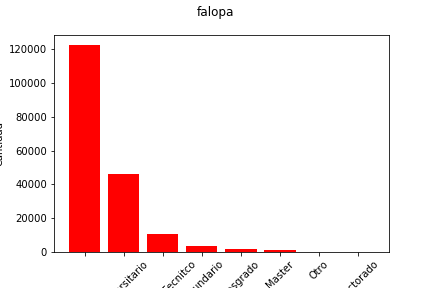

In [116]:
%matplotlib notebook
cant = usuarios_educacion_edad['estudio_en_curso'].value_counts()
estados = [1,2,3,4,5,6,7,8]
momos = ['', 'Universitario', 'Terciario/Tecnitco', 'Secundario', 'Posgrado', 'Master', 'Otro', 'Doctorado']
plt.bar(estados, cant, color = 'red')
plt.suptitle("Cantidad de personas por estudio en curso")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad")
plt.xticks(estados, momos, rotation=45)
plt.show()

<IPython.core.display.Javascript object>


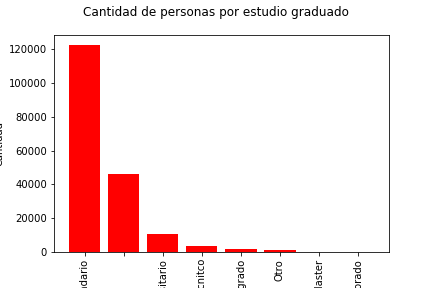

In [118]:
%matplotlib notebook
cant = usuarios_educacion_edad['estudio_en_curso'].value_counts()
estados = [1,2,3,4,5,6,7,8]
momos = ['Secundario', '', 'Universitario', 'Terciario/Tecnitco', 'Posgrado', 'Otro', 'Master', 'Doctorado']
plt.bar(estados, cant, color = 'red')
plt.suptitle("Cantidad de personas por estudio graduado")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad")
plt.xticks(estados, momos, rotation = 45)
plt.show()

El hecho de que en ambos gráficos hubiera una gran cantidad de gente en la que no se especificaba el estudio nos hizo pensar que era una buena idea investigar que estudio terminado tenía la gente que no tenía nada en curso y viceversa

<IPython.core.display.Javascript object>


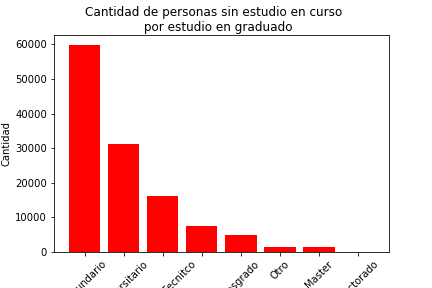

In [121]:
%matplotlib notebook
en_curso_vacio = usuarios_educacion_edad[usuarios_educacion_edad['estudio_en_curso'] == ""]
cant = en_curso_vacio['estudio_graduado'].value_counts()
estados = [1,2,3,4,5,6,7,8]
momos = ['Secundario', 'Universitario', 'Terciario/Tecnitco', '', 'Posgrado', 'Otro', 'Master', 'Doctorado']
plt.bar(estados, cant, color = 'red')
plt.suptitle("Cantidad de personas sin estudio en curso \n por estudio en graduado")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad")
plt.xticks(estados, momos, rotation=45)
plt.show()

<IPython.core.display.Javascript object>


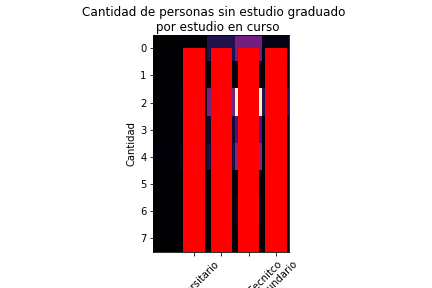

In [125]:
%matplotlib notebook
graduado_vacio = usuarios_educacion_edad[usuarios_educacion_edad['estudio_graduado'] == ""]
cant = graduado_vacio['estudio_en_curso'].value_counts()
estados = [1,2,3,4,5,6,7,8]
momos = ['Universitario', '', 'Terciario/Tecnitco', 'Secundario', 'Otro', 'Posgrado', 'Master', 'Doctorado']
plt.bar(estados, cant, color = 'red')
plt.suptitle("Cantidad de personas sin estudio graduado \n por estudio en curso")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad")
plt.xticks(estados, momos, rotation=45)
plt.show()

### Plots de vista general

Los siguientes dos gráficos los hicimos porque queríamos ver la distribución de datos básicos como sexo de los usuarios y zona del aviso, pero no consideramos que pudieramos conseguir mucha información de ellos

In [45]:
#Zona Oeste solo tiene dos registros y pertenece al GBA, por otra parte el resto de las zonas no está representado
#y por eso decidimos combinar las dos posibles categorías en una
sin_Oeste = avisos_detalles[avisos_detalles['nombre_zona'] != 'GBA Oeste']
oeste = avisos_detalles[avisos_detalles['nombre_zona'] == 'GBA Oeste']
oeste['nombre_zona'] = 'Gran Buenos Aires'
avisos_detalles = sin_Oeste.append(oeste)
avisos_detalles['nombre_zona'].value_counts()

C:\Users\gonza\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Gran Buenos Aires              12656
Capital Federal                  876
Buenos Aires (fuera de GBA)        2
Name: nombre_zona, dtype: int64

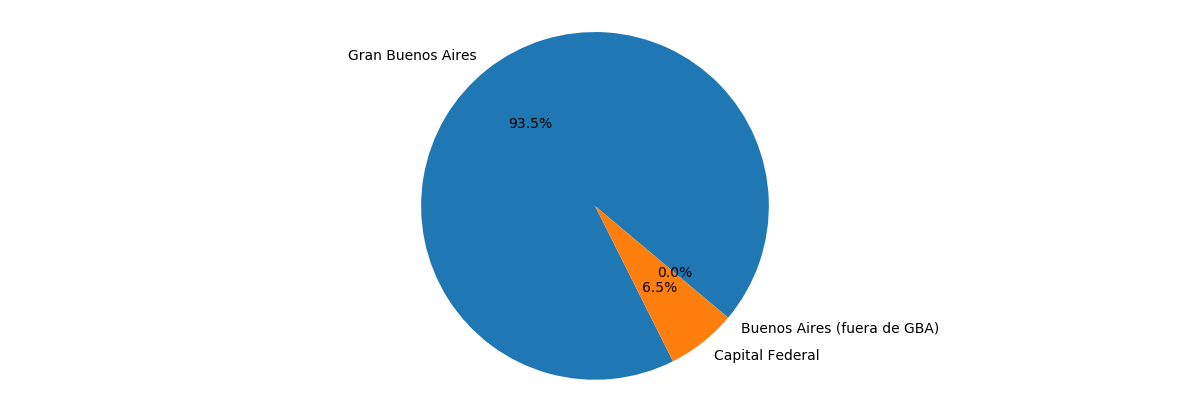

In [47]:
labels = ['Gran Buenos Aires', 'Capital Federal', 'Buenos Aires (fuera de GBA)']
sizes = avisos_detalles['nombre_zona'].value_counts().as_matrix()
#explode vector con un numero chico en la posicion del pedazo que se quiera alejar del centro
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = -40)
ax1.axis('equal')

plt.show()

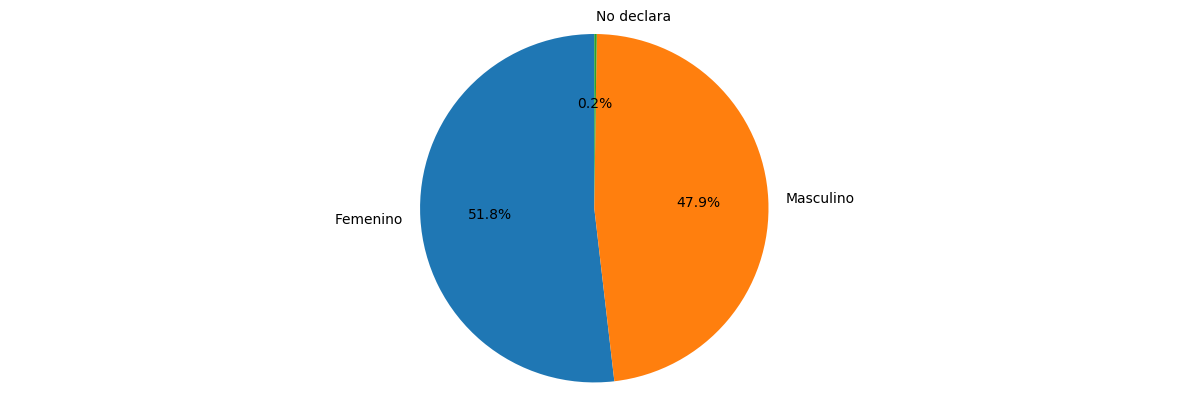

In [44]:
labels = ['Femenino', 'Masculino', 'No declara']
sizes = genero_edad_filtrado['sexo'].value_counts().as_matrix()
#explode vector con un numero chico en la posicion del pedazo que se quiera alejar del centro
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 90)
ax1.axis('equal')

plt.show()

### Plots de postulaciones por usuario

In [15]:
postulaciones_por_usuario_filtrado = pd.DataFrame({
    'postulaciones_totales': postulaciones_filtrado.groupby('idpostulante')['idaviso'].count(),
}).reset_index()
postulaciones_por_usuario_filtrado = postulaciones_por_usuario_filtrado.sort_values('postulaciones_totales')
print postulaciones_por_usuario_filtrado.postulaciones_totales.head(5)
print postulaciones_por_usuario_filtrado.postulaciones_totales.tail(5)

155006    1
40700     1
15583     1
159576    1
15581     1
Name: postulaciones_totales, dtype: int64
17657     1213
39789     1414
21841     1485
33610     1773
131087    3166
Name: postulaciones_totales, dtype: int64


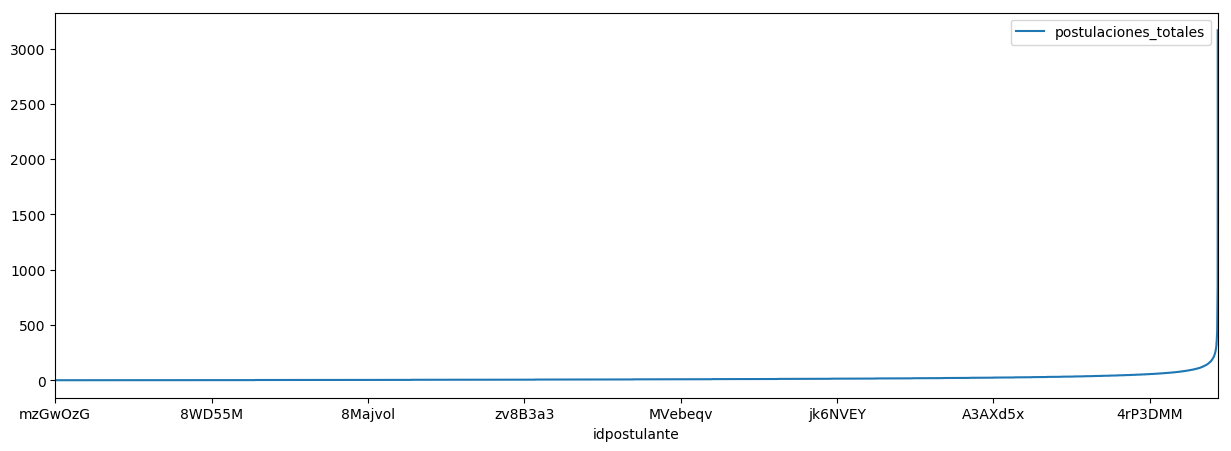

In [16]:
postulaciones_por_usuario_filtrado.plot(x='idpostulante', y='postulaciones_totales', kind='line')

In [17]:
postulaciones_por_usuario_sin_filtro = pd.DataFrame({
    'postulaciones_totales': postulaciones.groupby('idpostulante')['idaviso'].count(),
}).reset_index()
postulaciones_por_usuario_sin_filtro = postulaciones_por_usuario_sin_filtro.sort_values('postulaciones_totales')
print postulaciones_por_usuario_sin_filtro.postulaciones_totales.head(5)
print postulaciones_por_usuario_sin_filtro.postulaciones_totales.tail(5)
len(postulaciones_por_usuario_sin_filtro)

59628     1
137057    1
40544     1
40549     1
94726     1
Name: postulaciones_totales, dtype: int64
19108     1213
42947     1414
23612     1485
36281     1773
141436    3166
Name: postulaciones_totales, dtype: int64


200888

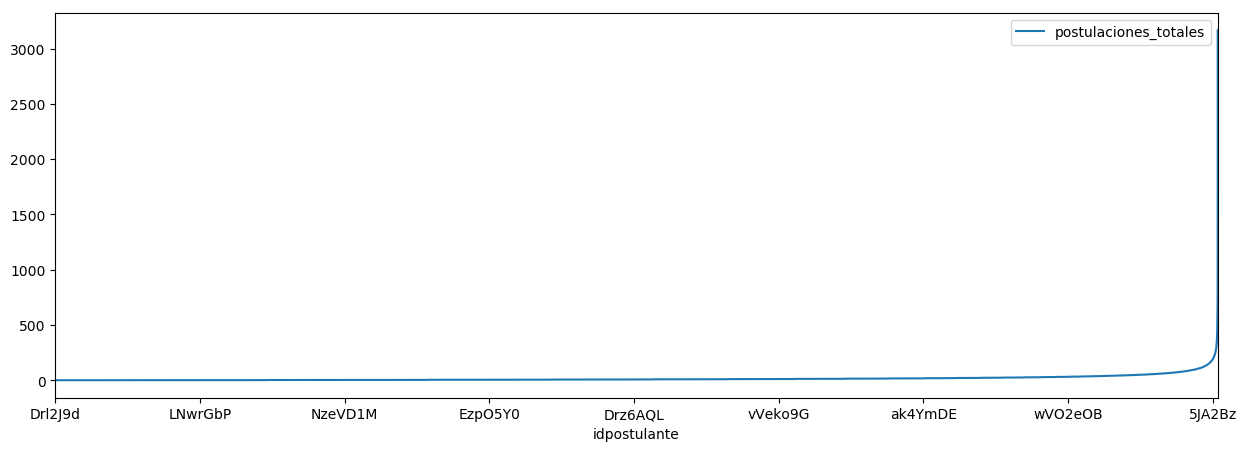

In [18]:
postulaciones_por_usuario_sin_filtro.plot(x='idpostulante', y='postulaciones_totales', kind='line')

In [19]:
# Como hacer un concat de series y eliminar duplicados
# idaviso_post_sin_fecha_nacimiento = postulaciones_sin_fecha_nacimiento.idaviso
# idaviso_visitas_sin_fecha_nacimiento = visitas_sin_fecha_nacimiento.idAviso
# len(idaviso_post_sin_fecha_nacimiento)
# len(idaviso_visitas_sin_fecha_nacimiento)
# avisos_de_postulantes_sin_fecha_nacimiento = pd.concat([idaviso_post_sin_fecha_nacimiento, idaviso_visitas_sin_fecha_nacimiento], ignore_index=True)
# avisos_de_postulantes_sin_fecha_nacimiento = avisos_de_postulantes_sin_fecha_nacimiento.drop_duplicates()

### Plots de avisos por área

Viendo como las áreas no eran demasiado categóricas sino que había una muy larga lista de posibilidades se nos ocurrió que podíamos ver cómo se distribuían los avisos con respecto al área

In [32]:
avisos_detalles['nombre_area'].value_counts()

Ventas                                   1659
Comercial                                 983
Administración                            901
Producción                                821
Programación                              576
Contabilidad                              416
Tecnologia / Sistemas                     388
Atención al Cliente                       347
Mantenimiento                             324
Recursos Humanos                          235
Gastronomia                               234
Oficios y Profesiones                     209
Soporte Técnico                           203
Logística                                 200
Call Center                               191
Almacén / Depósito / Expedición           184
Compras                                   170
Otros                                     153
Marketing                                 153
Administración de Personal                152
Recepcionista                             151
Transporte                        

In [33]:
avisos_detalles_sin_filtro = pd.DataFrame({
    'postulaciones_totales': avisos_detalles.groupby('nombre_area')['idaviso'].count(),
}).reset_index()
avisos_detalles_sin_filtro = avisos_detalles_sin_filtro.sort_values('postulaciones_totales')
print avisos_detalles_sin_filtro.postulaciones_totales.head(5)
print avisos_detalles_sin_filtro.postulaciones_totales.tail(5)
len(avisos_detalles_sin_filtro)

136    1
97     1
77     1
34     1
122    1
Name: postulaciones_totales, dtype: int64
132     576
130     821
2       901
27      983
170    1659
Name: postulaciones_totales, dtype: int64


173

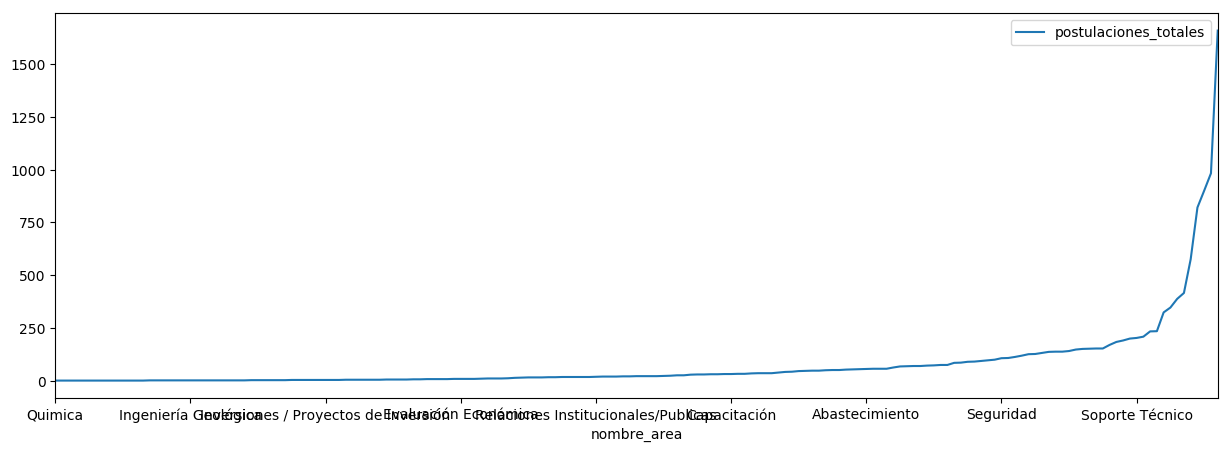

In [34]:
avisos_detalles_sin_filtro.plot(x='nombre_area', y='postulaciones_totales', kind='line')

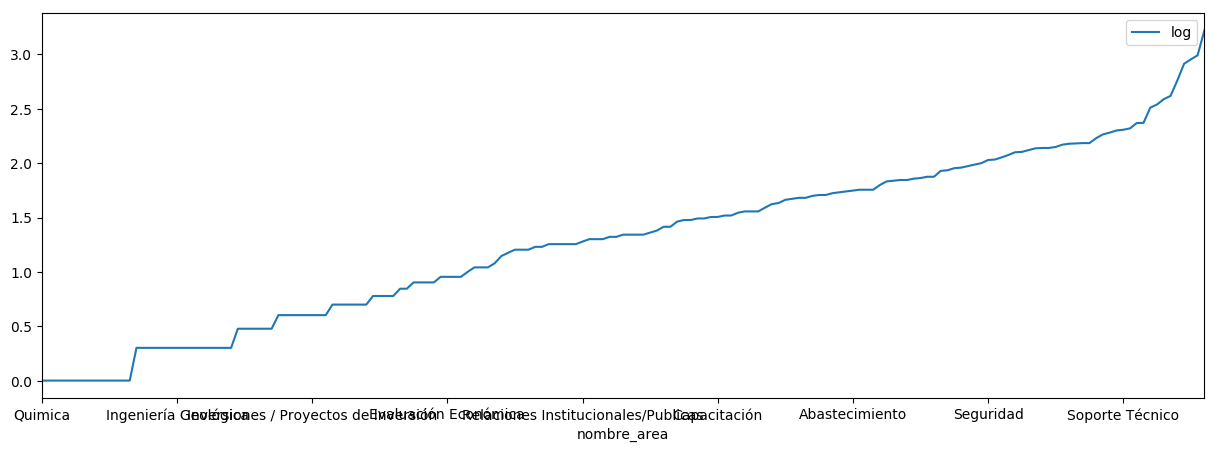

In [35]:
import math
avisos2 = avisos_detalles_sin_filtro
avisos2['log'] = avisos_detalles_sin_filtro['postulaciones_totales'].apply(lambda x: math.log10(x))
avisos_detalles_sin_filtro.plot(x='nombre_area', y='log', kind='line')

### Plot de postuldos por nivel y estudio

In [20]:
#funcionas auxiliares para graficar

def completoAEnum(completo):
    estudio = ['', 'Otro', 'Secundario', 'Terciario/Técnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
    for x in range(0,len(estudio)):
        if completo == estudio[x]:
            return x
    return 0
        
def aEnumNivel(nivel):
    if(nivel == 'Gerencia / Alta Gerencia / Dirección'):
        return 0
    if(nivel == 'Jefe / Supervisor / Responsable'):
        return 1
    if(nivel == 'Junior'):
        return 2
    if(nivel == 'Senior / Semi-Senior'):
        return 3
    return 4

In [21]:
#Se consigue un dataframe con el mayor estudio graduado y el nivel que 
#pide la publicación a la que se postuló como valires numéricos
mejor_nivel_estudio = pd.merge(postulaciones_filtrado, avisos_detalles, how='inner', on='idaviso')
preplot = mejor_nivel_estudio['estudio_graduado'].to_frame()
preplot['nivel'] = mejor_nivel_estudio['nivel_laboral']
preplot['nivel'] = preplot['nivel'].apply(lambda x: aEnumNivel(x))
preplot['estudio_graduado'] = preplot['estudio_graduado'].apply(lambda x: completoAEnum(x))

<IPython.core.display.Javascript object>


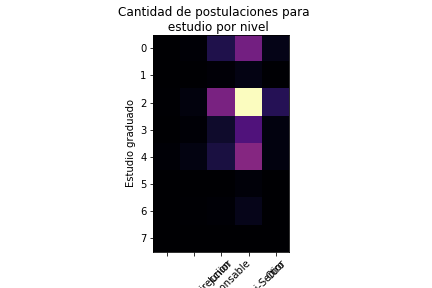

In [184]:
%matplotlib notebook
import math

preplot_matriz = preplot.as_matrix()
acumulador = np.zeros([8, 5], dtype = float)
for dupla in preplot_matriz:
    acumulador[dupla[0]][dupla[1]] = acumulador[dupla[0]][dupla[1]] + 1
plt.imshow(acumulador, cmap='magma', interpolation='nearest')
plt.suptitle("Cantidad de postulaciones para \n estudio por nivel")
plt.xlabel("Nivel buscado")
plt.ylabel("Estudio graduado")
plt.xticks((0,1,2,3,4), ('Gerencia / Alta Gerencia / Direccion', 'Jefe / Supervisor / Responsable', 'Junior', 'Senior / Semi-Senior', 'Otro'), rotation=45)
plt.show()

### Plots de postulaciones por hora

In [37]:
posts = postulaciones['fechapostulacion'].apply(lambda x: x.split(" ")[1].split(":")[0]).as_matrix()

am = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
pm =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for elem in posts:
    eleminto = int(elem)
    if(eleminto) < 12:
        am[eleminto] = am[eleminto] + 1
    else:
        pm[eleminto-12] = pm[eleminto-12] + 1

In [38]:
pmray = np.asarray(pm)
amray = np.asarray(am)

In [140]:
np.ones([3,1], int)

array([[1],
       [1],
       [1]])

<IPython.core.display.Javascript object>


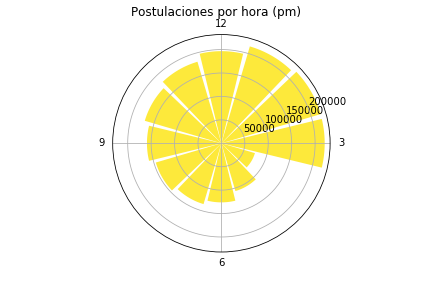

In [156]:
%matplotlib notebook
N = 12 #cantidad de horas
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = pmray
width = np.pi / 3.3 *  np.asarray([.5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5])
ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii, width=width, bottom=0.0)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.viridis(r / 10.))
    bar.set_alpha(.9)
    
angulos = [np.pi/2, 0, np.pi*1.5, np.pi]
horas = ["12", "3", "6", "9"]
plt.suptitle("Postulaciones por hora (pm)")
plt.xticks(angulos, horas)

plt.show()

<IPython.core.display.Javascript object>


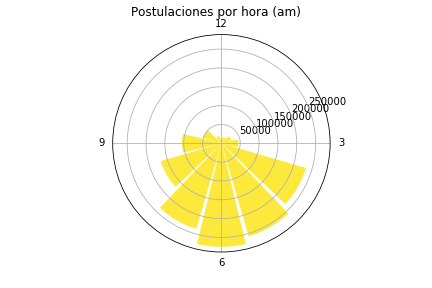

In [157]:
%matplotlib notebook
N = 12 #cantidad de horas
#theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = amray
#width = np.pi / 3.3 *  np.asarray([.5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5])
ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii, width=width, bottom=0.0)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.viridis(r / 10.))
    bar.set_alpha(.9)
    
plt.suptitle("Postulaciones por hora (am)")
plt.xticks(angulos, horas)

plt.show()

### Edades de los potulantes

Encontramos muchos casos de gente con una edad demasiado elevada como para ser reales. Muchas tienen aspecto de años cercanos. Hubo un caso en el que había una persona que tenía 12 años, que decidimos sacar. Decidimos arbitrariamente filtrar a los mayores de 100.

In [159]:
import dateutil 
edades = genero_edad_filtrado
edades['edades'] = edades['fechanacimiento'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%M-%d").date())
edades['edades'] = edades['edades'].apply(lambda x: int(dateutil.relativedelta.relativedelta(datetime.datetime.utcnow().date(),x).years))

C:\Users\gonza\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gonza\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [161]:
edades_extranias = edades[edades['edades'] > 100]
print(edades_extranias.shape)
edades_extranias

(9, 4)


,idpostulante,fechanacimiento,sexo,edades
56206,xkPwXwY,0031-12-11,FEM,1987
71458,LN85Y3b,0029-05-11,MASC,1989
130846,8M2R6pz,0024-02-09,FEM,1994
141832,A36Npjj,0033-09-14,FEM,1985
145683,dYjV0rb,0012-11-04,NO_DECLARA,2006
148638,GNZOvAv,0004-07-19,MASC,2014
149653,1QPQ8QL,0011-03-08,MASC,2007
154559,xkdvwm0,1775-07-09,MASC,243
164618,96X1loa,1917-07-08,MASC,101


In [49]:
edades = edades[edades['edades'] < 100]
edades = edades[edades['edades'] > 17]
array_edades = edades['edades'].as_matrix()

In [176]:
acum_edades = np.empty([10, 1], dtype = float)
for elem in array_edades:
    acum_edades[int(elem/10)] = acum_edades[int(elem/10)] + 1
xaxis = []
for x in range (0, 100, 10):
    acum_edades[x/10] = np.log1p(acum_edades[x/10])
    xaxis.append(str(x))

<IPython.core.display.Javascript object>


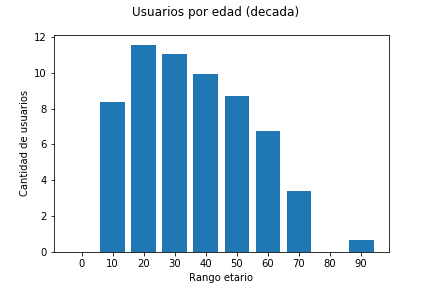

([<matplotlib.axis.XTick at 0xaa557908>,
 <a list of 10 Text xticklabel objects>)

In [181]:
%matplotlib notebook
cosa = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.bar(cosa, acum_edades)
plt.suptitle("Usuarios por edad (decada)")
plt.xlabel("Rango etario")
plt.ylabel("Cantidad de usuarios")
plt.xticks(cosa, xaxis)

### Cantidades de postulaciones por aviso

In [55]:
postulaciones_filtrado['idaviso'].value_counts()

1112334791    9332
1112033906    9309
1112204682    8814
1112094756    8581
1112345900    8140
1112319451    7747
1112298966    7363
1112262494    7348
1112305277    6973
1112296264    6814
1112334788    6481
1112260584    5994
1112344973    5761
1112316288    5643
1111753681    5540
1112349037    5534
1112196813    5480
1112120281    5458
1112280937    5331
1112299531    5184
1112206678    5149
1112307266    5143
1111644947    5073
1112337868    5068
1112260111    5058
1112327106    5046
1112293625    4896
1112347329    4893
1112345051    4870
1112303105    4790
              ... 
1112205391       1
1112211072       1
1112219324       1
1112231656       1
1112209483       1
1112209349       1
1112205299       1
1112208450       1
1112369004       1
1112210516       1
1112242531       1
1112203053       1
1112308112       1
1112241010       1
1112361980       1
1111946901       1
1112308118       1
1112201875       1
1112361607       1
1112308046       1
1112204755       1
1112308026  

<IPython.core.display.Javascript object>


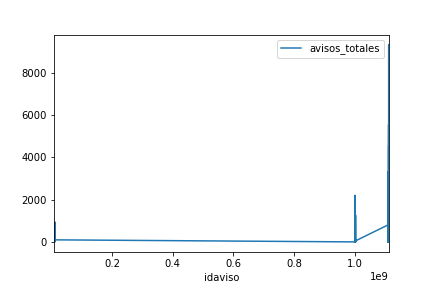

In [182]:
meem = pd.DataFrame({#postulaciones_filtrado['idaviso'].value_counts()
    'avisos_totales': postulaciones_filtrado.groupby('idaviso')['idpostulante'].count(),
}).reset_index()
meem.plot(x='idaviso', y='avisos_totales', kind='line')

<IPython.core.display.Javascript object>


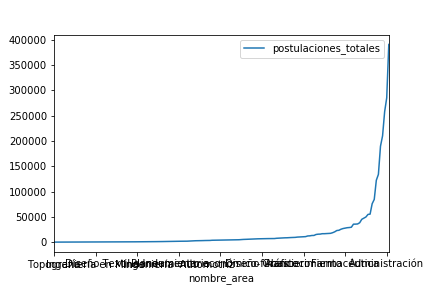

In [62]:
postutalles2.plot(x='nombre_area', y='postulaciones_totales', kind='line')

### Plot cantidad de avisos por nivel buscado

In [61]:
postutalles2 = pd.DataFrame({
    'postulaciones_totales': postutalles.groupby('nombre_area')['idaviso'].count(),
}).reset_index()
postutalles2 = postutalles2.sort_values('postulaciones_totales')
print avisos_detalles_sin_filtro.postulaciones_totales.head(5)
print avisos_detalles_sin_filtro.postulaciones_totales.tail(5)
len(avisos_detalles_sin_filtro)

136    1
97     1
77     1
34     1
122    1
Name: postulaciones_totales, dtype: int64
132     576
130     821
2       901
27      983
170    1659
Name: postulaciones_totales, dtype: int64


173

<IPython.core.display.Javascript object>


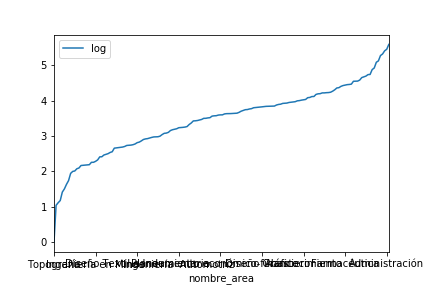

In [63]:
postutalles3 = postutalles2
postutalles3['log'] = postutalles2['postulaciones_totales'].apply(lambda x: math.log10(x))
postutalles3.plot(x='nombre_area', y='log', kind='line')

### Plot postulaciones por area 

In [58]:
avisos_detalles['nivel_laboral'].value_counts()

Senior / Semi-Senior                    9407
Junior                                  2216
Otro                                     921
Jefe / Supervisor / Responsable          809
Gerencia / Alta Gerencia / Dirección     181
Name: nivel_laboral, dtype: int64

<IPython.core.display.Javascript object>


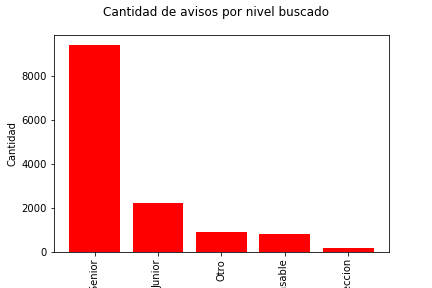

In [183]:
#grafico de barras de tipo de estudio por estado
%matplotlib notebook
cant = avisos_detalles['nivel_laboral'].value_counts().as_matrix()
estados = [1,2,3,4,5]
nivel = ['Senior / Semi-Senior', 'Junior', 'Otro', 'Jefe / Supervisor / Responsable', 'Gerencia / Alta Gerencia / Direccion']
plt.bar(estados, cant, color = 'red')
plt.suptitle("Cantidad de avisos por nivel buscado")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad")
plt.xticks(estados, nivel, rotation = 'vertical')
plt.show()

<IPython.core.display.Javascript object>


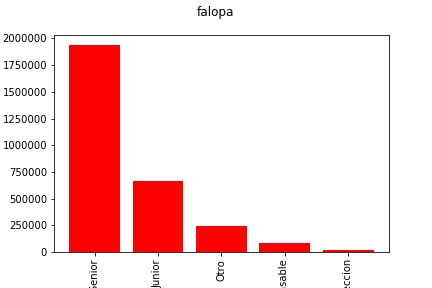

In [64]:
#postulaciones por nivel
%matplotlib notebook
cant = postutalles['nivel_laboral'].value_counts().as_matrix()
estados = [1,2,3,4,5]
momos = ['Senior / Semi-Senior', 'Junior', 'Otro', 'Jefe / Supervisor / Responsable', 'Gerencia / Alta Gerencia / Direccion']
plt.bar(estados, cant, color = 'red')
plt.suptitle("falopa")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad")
plt.xticks(estados, momos, rotation = 'vertical')
plt.show()

### Plot de postuación por estudios

<IPython.core.display.Javascript object>


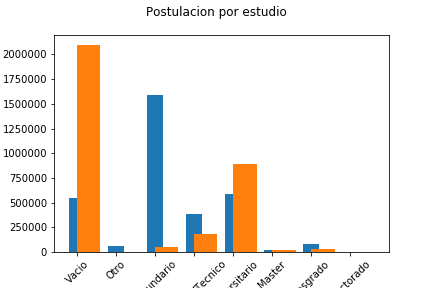

In [190]:
#postulaciones por estudio
%matplotlib notebook
#postulaciones_filtrado
arrGrad = postulaciones_filtrado['estudio_graduado'].apply(lambda x: completoAEnum(x)).values
arrCurs = postulaciones_filtrado['estudio_en_curso'].apply(lambda x: completoAEnum(x)).values
cantCurso = [0,0,0,0,0,0,0,0]
cantGrad = [0,0,0,0,0,0,0,0]
for x in range (0,len(arrGrad)):
    cantGrad[arrGrad[x]] = cantGrad[arrGrad[x]] + 1
    cantCurso[arrCurs[x]] = cantCurso[arrCurs[x]] + 1
    
number = [0,1,2,3,4,5,6,7]
estudios = ['Vacio', 'Otro', 'Secundario', 'Terciario/Tecnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
plt.bar(number, cantGrad, width = 0.4)
plt.bar(number, cantCurso, width = 0.6, align = 'edge')
plt.suptitle("Postulacion por estudio")
plt.xlabel("Estudio\n Naranja: En curso\n Azul: Graduado")
plt.ylabel("Cantidad de postulaciones")
plt.xticks(number, estudios, rotation=45)
plt.show()

<IPython.core.display.Javascript object>


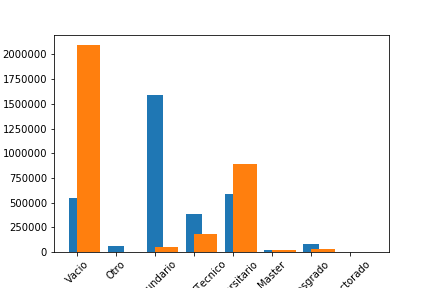

In [192]:
#gente por estudio
%matplotlib notebook
arrGrad = postulaciones_filtrado['estudio_graduado'].apply(lambda x: completoAEnum(x)).values
arrCurs = postulaciones_filtrado['estudio_en_curso'].apply(lambda x: completoAEnum(x)).values
cantCurso = [0,0,0,0,0,0,0,0]
cantGrad = [0,0,0,0,0,0,0,0]
for x in range (0,len(arrGrad)):
    cantGrad[int(arrGrad[x])] = cantGrad[int(arrGrad[x])] + 1
    cantCurso[int(arrCurs[x])] = cantCurso[int(arrCurs[x])] + 1

number = [0,1,2,3,4,5,6,7]
estudios = ['Vacio', 'Otro', 'Secundario', 'Terciario/Tecnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
plt.bar(number, cantGrad, width = 0.4)
plt.bar(number, cantCurso, width = 0.6, align = 'edge')
plt.xlabel("Estudio\n Naranja: En curso\n Azul: Graduado")
plt.ylabel("Cantidad de postulaciones")
plt.xticks(number, estudios, rotation=45)
plt.show()

### Plots con respecto a los días de la semana

In [193]:
def day2number(day):
    if(day == "Monday"):
        return 0
    if(day == "Tuesday"):
        return 1
    if(day == "Wednesday"):
        return 2
    if(day == "Thursday"):
        return 3
    if(day == "Friday"):
        return 4
    if(day == "Saturday"):
        return 5
    return 6
    

In [206]:
count_dias_post = [0, 0, 0, 0, 0, 0, 0]
vecPostulacion = postulaciones_filtrado['fechapostulacion'].apply(lambda x: datetime.date(int(x.split(" ")[0].split("-")[0]),int(x.split(" ")[0].split("-")[1]),int(x.split(" ")[0].split("-")[2])).strftime("%A"))
for elem in vecPostulacion:
    count_dias_post[day2number(elem)] = count_dias_post[day2number(elem)] + 1

<IPython.core.display.Javascript object>


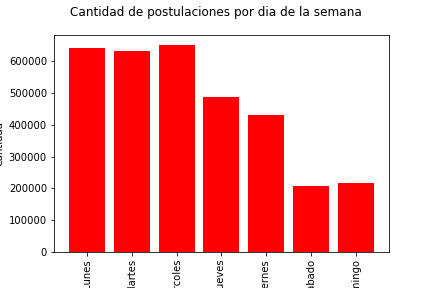

In [207]:
#Cantidad de postulaciones por día de la semana
%matplotlib notebook
estados = [1,2,3,4,5,6,7]
dias = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
plt.bar(estados, count_dias_post, color = 'red')
plt.suptitle("Cantidad de postulaciones por dia de la semana")
plt.xlabel("Dia")
plt.ylabel("Cantidad")
plt.xticks(estados, dias, rotation = 'vertical')
plt.show()

In [208]:
count_dias_visitas = [0, 0, 0, 0, 0, 0, 0]
vecVisitas = visitas_filtrado['timestamp'].apply(lambda x: datetime.date(int(x.split("T")[0].split("-")[0]),int(x.split("T")[0].split("-")[1]),int(x.split("T")[0].split("-")[2])).strftime("%A"))
for elem in vecVisitas:
    count_dias_visitas[day2number(elem)] = count_dias_visitas[day2number(elem)] + 1

<IPython.core.display.Javascript object>


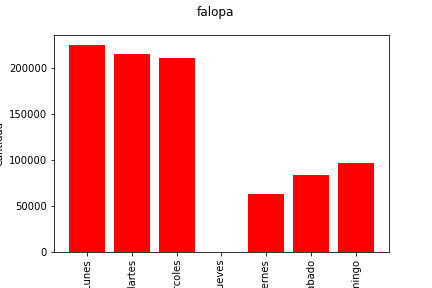

In [210]:
%matplotlib notebook
plt.bar(estados, count_dias_visitas, color = 'red')
plt.suptitle("falopa")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad")
plt.xticks(estados, momos, rotation = 'vertical')
plt.show()

In [77]:
visitas_filtrado.shape

(895478, 7)

In [213]:
#funcion harcodeada para buscar jueves en las visitas
def esJueves(preFecha):
    fecha = preFecha.split("T")[0].split("-")
    if fecha[1] == "01":
        return (fecha in (4, 11, 18, 25))
    return (fecha in (1, 8, 15, 22))

In [79]:
hayJueves = visitas['timestamp'].apply(lambda x: esJueves(x))

nrio = False
for dia in hayJueves:
    nrio = nrio or dia
nrio

### Plot de horas en las que se postula para cada día de la semana

<IPython.core.display.Javascript object>


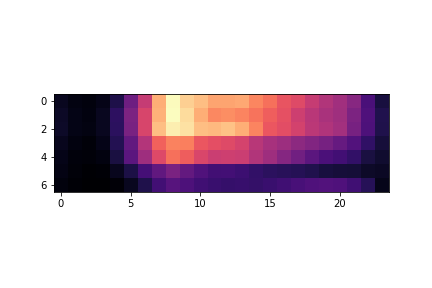

In [212]:
%matplotlib notebook

count_hora = np.zeros([7,24], dtype = int)

aux = postulaciones_filtrado
aux['dia'] = aux['fechapostulacion'].apply(lambda x: datetime.date(int(x.split(" ")[0].split("-")[0]),int(x.split(" ")[0].split("-")[1]),int(x.split(" ")[0].split("-")[2])).strftime("%A"))
aux['hora'] = aux['fechapostulacion'].apply(lambda x: x.split(" ")[1].split(":")[0])

lun = aux[aux['dia'] == "Monday"]['hora'].as_matrix()
mar = aux[aux['dia'] == "Tuesday"]['hora'].as_matrix()
mie = aux[aux['dia'] == "Wednesday"]['hora'].as_matrix()
jue = aux[aux['dia'] == "Thursday"]['hora'].as_matrix()
vie = aux[aux['dia'] == "Friday"]['hora'].as_matrix()
sab = aux[aux['dia'] == "Saturday"]['hora'].as_matrix()
dom = aux[aux['dia'] == "Sunday"]['hora'].as_matrix()

sumhora = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

iterar = (lun, mar, mie, jue, vie, sab, dom)

for x in range (0,7):
    for hora in iterar[x]:
        count_hora[x][int(hora)-1] = count_hora[x][int(hora)-1] + 1

plt.imshow(count_hora, cmap='magma', interpolation='nearest')
plt.show()